In [1]:
from datasets.coco_dataset import CocoDataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
transforms = A.Compose([
#     A.Normalize(),
#     ToTensor()
])

In [2]:
dataset = CocoDataset(
    root_dir = 'datasets/vinai512/images/train',
    ann_path = 'datasets/vinai512/annotations/vinai512_train.json',
    transforms = None,
    train=True
)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


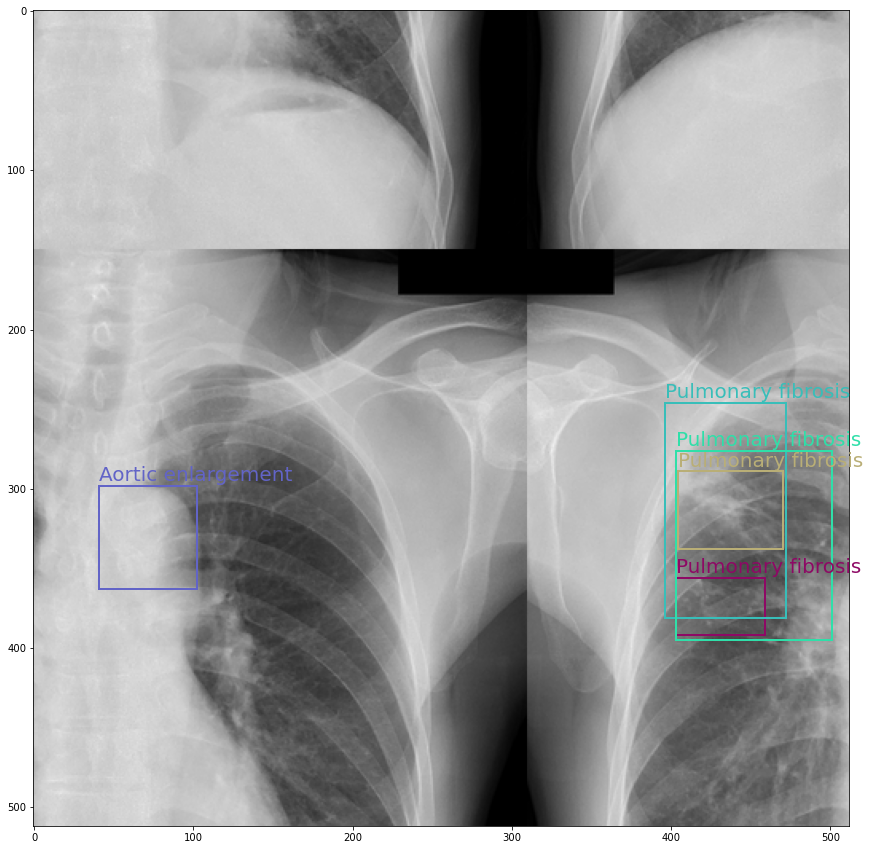

In [3]:
dataset.visualize_item(0)

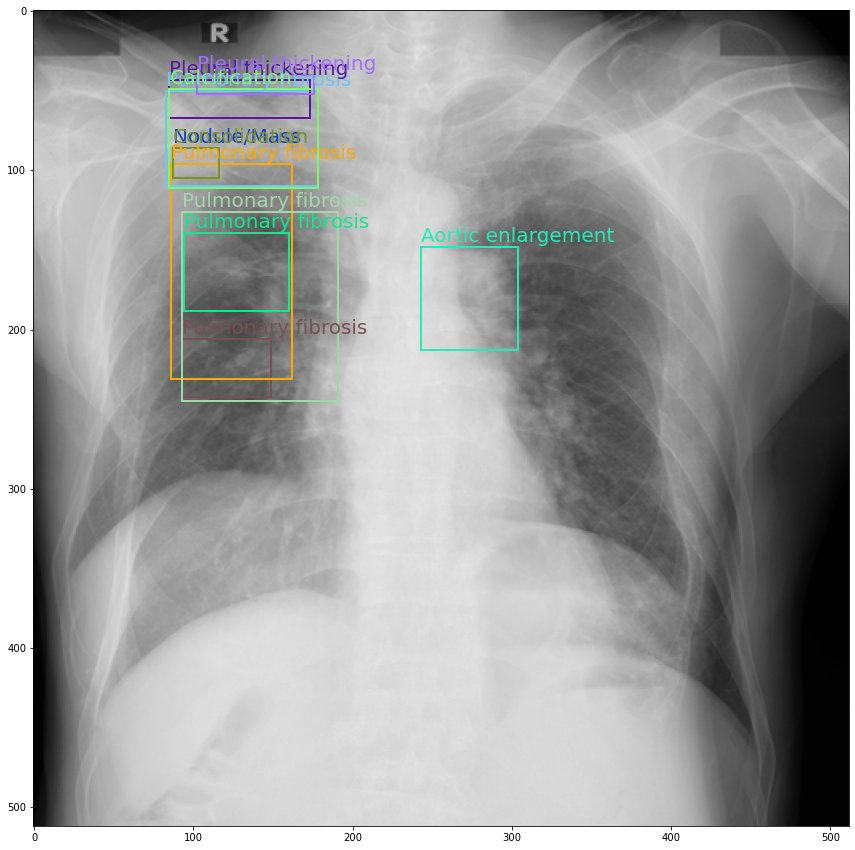

In [5]:
dataset.visualize_item(0)

In [ ]:
dataset.visualize_item(0)

In [ ]:
def load_mixup_image_and_boxes(dataset, index):
    item = dataset[index]
    image, boxes, labels = item['img'], item['box'], item['label']
    
    
    item = dataset[random.randint(0, len(dataset.image_ids) - 1)]
    r_image, r_boxes, r_labels = item['img'], item['box'], item['label']
    
    return (image+r_image)/2, np.vstack((boxes, r_boxes)).astype(np.int32), np.concatenate((labels, r_labels))

In [ ]:
def load_cutmix_image_and_boxes(dataset, index, imsize=512):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index, index, index, index] #+ #[random.randint(0, len(dataset.image_ids) - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        result_labels = np.array([], dtype=np.int)
        
        for i, index in enumerate(indexes):
            item = dataset[index]
            image, boxes, labels = item['img'], item['box'], item['label']
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)
            result_labels = np.concatenate((result_labels, labels))
            
        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        index_to_use = np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)
        result_boxes = result_boxes[index_to_use]
        result_labels = result_labels[index_to_use]
        
        return result_image, result_boxes, result_labels

In [ ]:
result_image, result_boxes, result_labels = load_mixup_image_and_boxes(dataset,0)

In [ ]:
result_image, result_boxes, result_labels = load_cutmix_image_and_boxes(dataset,0)

In [ ]:
dataset.visualize(result_image, result_boxes, result_labels)

In [ ]:
dataset.visualize_item(0)